### Imports

In [174]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, percentileofscore
import modules.data_processing

In [2]:
## Reloading, relancer cette cell si vous modifiez les fonctions
plt.style.use('default')
importlib.reload(modules.data_processing)
from modules.data_processing import *

In [3]:
DATA_PATH = './data/wiki-RfA.txt'

### Preparing Data

In [4]:
wiki_df = extract_data(DATA_PATH)
process_dataframe(wiki_df)

In [5]:
wiki_df.head(10)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1
5,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1
6,Ramaksoud2000,BDD,1,1,2013,2013-04-20 02:00:00,'''Support''' per noms. I don't see a reason n...,1
7,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1
8,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1
9,Someguy1221,BDD,1,1,2013,2013-04-20 03:09:00,'''Support''' because I see no good reason not...,1


### Introduction to data analysis of Wiki-Rfa dataset

In this notebook, we delve into the disparities among various variables influencing the acceptance or rejection of candidates in elections, aiming to uncover the factors leading to a successful outcome.

We will follow the steps below :

**Step 1: Average Votes per participant and influence of voter's activity**

Our exploration kicks off by voters' previous voting activity, calculating their average votes per year before a specific election. Are there emerging influencers within the community, and does their activity correlate with election outcomes?

**Step 2: Influence of previous participation before running for adminship**

Moving on, we explore candidate previous participation in the voting process before running for adminship. We analyze the correlation between the outcome of an election and the positive, negative and neutral votes fraction and the length of comments made by candidates in the votes their pre-candidacy votes. Do these early indicators play a role foreshadow success?

**Step 3: Margins and Outcomes - For/Against Votes Analysis**

Shifting gears, we analyze the margins by which candidates secure victory or face defeat in adminship elections. How do these margins vary for different categories of election outcomes?

**Step 4: Neutral Ground - Analyzing Neutral Votes**

In our final step, we turn our attention to neutrality. Exploring the number and rate of neutral votes, we seek to understand their correlation with election outcomes. Do candidates with a higher proportion of neutral votes encounter a different fate? 

### Average Votes per participant and influence of voter's activity

In [7]:
def add_past_voter_activity(row):
    src = row['SRC']
    dat = row['DAT']
    election_id = row['ELECTION_ID']
    past_votes_df = wiki_df[(wiki_df['SRC'] == src) & (wiki_df['DAT'] < dat)]
    nb_votes_before = len(past_votes_df['ELECTION_ID'])
    first_date_vote = past_votes_df['DAT'].min() if nb_votes_before != 0 else dat

    nb_years_from_first_vote = np.floor((dat - first_date_vote) / np.timedelta64(1, 'Y'))
    avg_votes_before = nb_votes_before / (nb_years_from_first_vote + 1)

    return pd.Series({
        'ELECTION_ID': election_id,
        'SRC': src,
        'NB_VOTES_BEFORE': nb_votes_before,
        'AVG_VOTES_BEFORE': avg_votes_before
    })

wiki_df_past_activity = wiki_df[['ELECTION_ID', 'SRC', 'DAT']].drop_duplicates()
wiki_df_past_activity = wiki_df_past_activity.apply(add_past_voter_activity, axis=1)

In [13]:
wiki_df_past_activity['ELECTION_ID'] = wiki_df_past_activity['ELECTION_ID'].astype(int)
wiki_df_past_activity['AVG_VOTES_BEFORE'] = wiki_df_past_activity['AVG_VOTES_BEFORE'].round(1)

wiki_df_past_activity.to_csv('./data/wiki-with-past-activity', index=False)
wiki_df_past_activity

,ELECTION_ID,SRC,NB_VOTES_BEFORE,AVG_VOTES_BEFORE
0,1,Steel1943,3.0,3.0
1,1,Cuchullain,1.0,0.3
2,1,INeverCry,18.0,18.0
3,1,Cncmaster,13.0,13.0
4,1,Miniapolis,35.0,35.0
...,...,...,...,...
198270,3926,172,0.0,0.0
198271,3927,Angela,2.0,2.0
198272,3927,Jiang,0.0,NaN
198273,3927,Pakaran,0.0,0.0


In [14]:
wiki_past = pd.read_csv('./data/wiki-with-past-activity')
wiki_past

,ELECTION_ID,SRC,NB_VOTES_BEFORE,AVG_VOTES_BEFORE
0,1,Steel1943,3.0,3.0
1,1,Cuchullain,1.0,0.3
2,1,INeverCry,18.0,18.0
3,1,Cncmaster,13.0,13.0
4,1,Miniapolis,35.0,35.0
...,...,...,...,...
197474,3926,172,0.0,0.0
197475,3927,Angela,2.0,2.0
197476,3927,Jiang,0.0,NaN
197477,3927,Pakaran,0.0,0.0


In [15]:
wiki_df[wiki_df['ELECTION_ID'].isin([3927, 3928])]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.,3927
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --,3927
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....,3927
198274,Jimregan,Zanimum,1,1,2003,NaT,"Support - anyone who can write so much, and so...",3928


We can notice that the rows having the average past number of votes per year are the ones that have missing values in the DAT column of the original dataframe

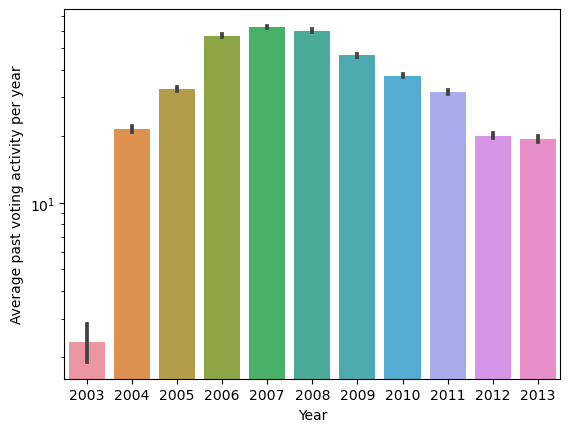

In [16]:
wiki_df_past_per_year = pd.merge(wiki_df, wiki_df_past_activity, on=['ELECTION_ID', 'SRC'])
sns.barplot(x='YEA', y='AVG_VOTES_BEFORE', data=wiki_df_past_per_year)
plt.xlabel('Year')
plt.ylabel('Average past voting activity per year')
plt.yscale('log')

We observe that the highest values in average of the past voting activity are around 2006-2008, with values around 60. This suggests that, during this period, voters participating in elections had in average a history of about 60 participations per year before the voting day.

This sheds light on a subset of voters who consistently engage in the voting process across multiple years. Their sustained involvement may wield influence over election outcomes, making them a particularly interesting group to examine.

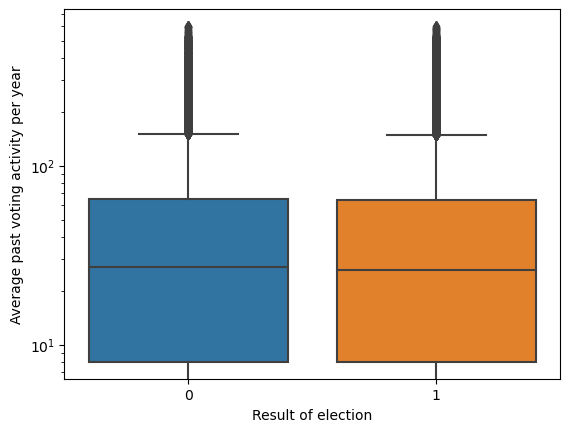

In [17]:
sns.boxplot(x='RES', y='AVG_VOTES_BEFORE', data=wiki_df_past_per_year)
plt.xlabel('Result of election')
plt.ylabel('Average past voting activity (participations / year)')
plt.yscale('log')

The boxplot suggests comparable distributions of past voting activity for elections leading to the acceptance and rejection of candidates. Let's perform a statistical test for confirmation.

In [18]:
data_res_0 = wiki_df_past_per_year[wiki_df_past_per_year['RES'] == 0]['AVG_VOTES_BEFORE'].dropna()
data_res_1 = wiki_df_past_per_year[wiki_df_past_per_year['RES'] == 1]['AVG_VOTES_BEFORE'].dropna()

t_stat, p_value = ttest_ind(data_res_0, data_res_1, alternative='greater')

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 4.438446651585308
P-value: 4.53302613064258e-06


The p-value is less than 0.05, indicating that there is a significant difference in average past voting activity between elections leading to the acceptance and rejection of candidates. This implies that past voting activity may indeed play a role in influencing election outcomes, as the null hypothesis of equal average past voting activity for both groups is rejected.

Let's now perform a year by year analysis to see if this hypothesis stands.

C:\Users\User\AppData\Local\Temp\ipykernel_17080\358689362.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_17080\358689362.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


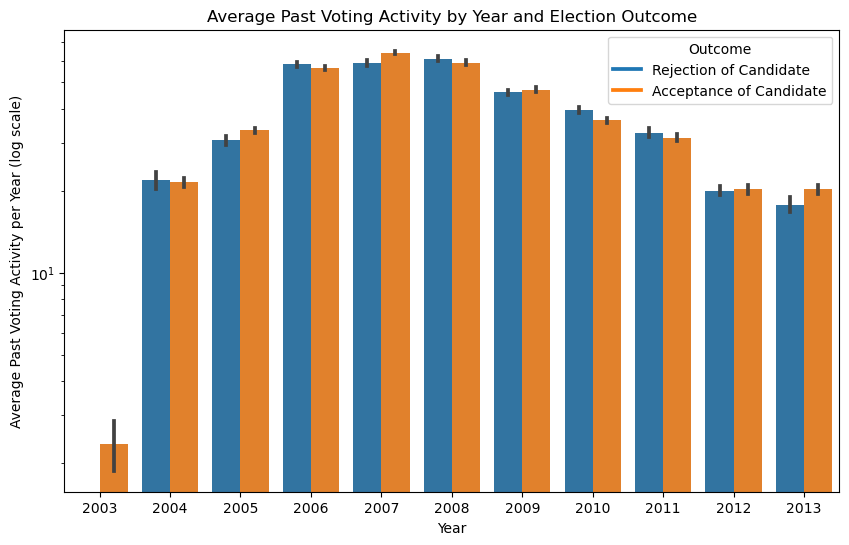

In [25]:
plt.figure(figsize=(10, 6))

sns.barplot(x='YEA', y='AVG_VOTES_BEFORE', hue='RES', data=wiki_df_past_per_year)

plt.xlabel('Year')
plt.ylabel('Average Past Voting Activity per Year (log scale)')
plt.yscale('log')
plt.title('Average Past Voting Activity by Year and Election Outcome')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

In [26]:
unique_years = wiki_df_past_per_year['YEA'].unique()

for year in unique_years:
    data_res_0 = wiki_df_past_per_year[(wiki_df_past_per_year['RES'] == 0) & (wiki_df_past_per_year['YEA'] == year)]['AVG_VOTES_BEFORE'].dropna()
    data_res_1 = wiki_df_past_per_year[(wiki_df_past_per_year['RES'] == 1) & (wiki_df_past_per_year['YEA'] == year)]['AVG_VOTES_BEFORE'].dropna()

    t_stat, p_value = ttest_ind(data_res_0, data_res_1)

    print(f"\nYear: {year}")
    print("Average Past Voting Activity in unsuccessful elections :", data_res_0.mean())
    print("Average Past Voting Activity in successful elections :", data_res_1.mean())
    print("T-statistic:", t_stat)
    print("P-value:", p_value)


Year: 2013
Average Past Voting Activity in unsuccessful elections : 17.775069252077564
Average Past Voting Activity in successful elections : 20.242683421159306
T-statistic: -3.451068639345947
P-value: 0.0005648902159396644

Year: 2012
Average Past Voting Activity in unsuccessful elections : 19.994597126795753
Average Past Voting Activity in successful elections : 20.235980301631276
T-statistic: -0.42046279292606975
P-value: 0.6741614138508498

Year: 2011
Average Past Voting Activity in unsuccessful elections : 32.58852580764946
Average Past Voting Activity in successful elections : 31.33755151098901
T-statistic: 1.6303327512888597
P-value: 0.10306817489334505

Year: 2010
Average Past Voting Activity in unsuccessful elections : 39.645786046511624
Average Past Voting Activity in successful elections : 36.24788797592871
T-statistic: 5.112881468253398
P-value: 3.214632394359845e-07

Year: 2009
Average Past Voting Activity in unsuccessful elections : 45.90573222604821
Average Past Voting 

When we break down the analysis year by year, we notice that the difference in past activity of voters for elections leading to rejection and acceptance of the candidate is not statistically significant for the years 2004, 2009, 2011, and 2012.

These specific years show p-values greater than the conventional significance level of 0.05, suggesting that, in those years, the observed differences in average past voting activity between the two outcomes could be attributed to random chance. It's essential to consider the nuances of each year and recognize that the influence of past voting activity on election outcomes may vary over time.

Note that the data for the year 2003 does not include any elections leading to the rejection of the candidate, this explain the NaN values observed in the t-test.

### Influence of previous participation before running for adminship

In [139]:
elections_df = create_elections_df(wiki_df)

For each candidate, we investigate the votes they cast before the start date of their election. We gather information on the total number of positive, negative, and neutral votes the candidate made, along with the average length of the comments they provided.

In [28]:
def summarize_before_adminship(row):
    election_id = row['ELECTION_ID']
    candidate = row['TGT']
    start_date = row['Earliest Voting Date']
    res = row['RES']
    
    candidate_votes_before = wiki_df[(wiki_df['SRC'] == candidate) & (wiki_df['DAT'] < start_date)]
    
    num_votes_no = (candidate_votes_before['VOT'] == -1).sum()
    num_votes_yes = (candidate_votes_before['VOT'] == 1).sum()
    num_votes_neutral = (candidate_votes_before['VOT'] == 0).sum()
    
    avg_comment_length = candidate_votes_before['TXT'].str.len().mean()
    
    return pd.Series({
        'ELECTION_ID': election_id,
        'TGT': candidate,
        'RES': res,
        'TotalNumPrevVotes' : num_votes_no + num_votes_yes + num_votes_neutral,
        'NumPrevVotesNo': num_votes_no,
        'NumPrevVotesYes': num_votes_yes,
        'NumPrevVotesNeutral': num_votes_neutral,
        'AvgPrevCommentLength': avg_comment_length
    })


summary_before_adminship_df = elections_df[['ELECTION_ID', 'TGT', 'RES', 'Earliest Voting Date']].drop_duplicates()
summary_before_adminship_df = summary_before_adminship_df.apply(summarize_before_adminship, axis=1)

In [37]:
summary_before_adminship_df['AvgPrevCommentLength'] = summary_before_adminship_df['AvgPrevCommentLength'].fillna(0)

summary_before_adminship_df

,ELECTION_ID,TGT,RES,TotalNumPrevVotes,NumPrevVotesNo,NumPrevVotesYes,NumPrevVotesNeutral,AvgPrevCommentLength
0,1,BDD,1,3,0,2,1,250.666667
1,2,Bilby,1,11,3,7,1,568.181818
2,3,Darkwind,1,0,0,0,0,0.000000
3,4,INeverCry,1,8,2,6,0,74.375000
4,5,Jason Quinn,1,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,0,0,0,0,0.000000
3924,3925,Ugen64,1,0,0,0,0,0.000000
3925,3926,Vancouverguy,1,0,0,0,0,0.000000
3926,3927,WhisperToMe,1,0,0,0,0,0.000000


Now that we have the necessary information, we categorize the candidate into two groups: 'Without Previous Votes' if the candidate did not participate as a voter in any election before the beginning of their election and 'With Previous Votes' otherwise.

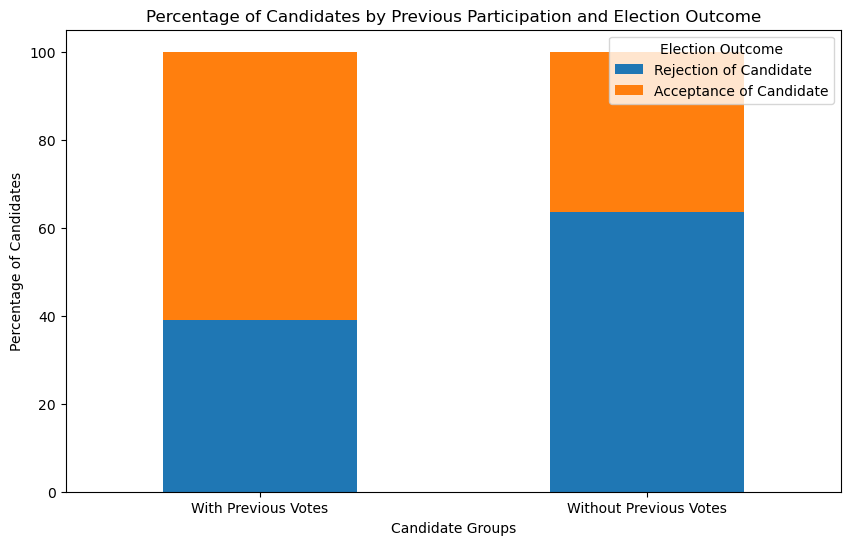

In [56]:
percentage_df = summary_before_adminship_df.groupby(summary_before_adminship_df['TotalNumPrevVotes'].eq(0).map({True: 'Without Previous Votes', False: 'With Previous Votes'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Candidate Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by Previous Participation and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
plt.xticks(rotation=0)

plt.show()

In [57]:
percentage_df

RES,0,1
TotalNumPrevVotes,,
With Previous Votes,38.980510,61.019490
Without Previous Votes,63.622211,36.377789


The bar chart reveals a contrast between candidates with prior participation in the voting process and those without. Notably, 61% of candidates with previous engagement were successfully accepted as administrators, whereas only 36% of candidates lacking prior participation received the same outcome.

To validate this observed difference statistically, let's conduct a hypothesis test.

Since we are comparing acceptance rates (a binary outcome) based on a categorical variable (previous participation), a chi-square test for independence is more suitable as it is used when analyzing the association between two categorical variables.

In [61]:
chi2, p, _, _ = chi2_contingency(percentage_df)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 11.186178160495032
P-value: 0.0008240891240052479


At a significance level of 0.05, the p-value falls below this threshold. Therefore, with 95% confidence, we reject the null hypothesis. This indicates a significant difference in acceptance rates between candidates with and without previous participation in the voting process.

Let's now condider the candidates who participated at least once in the previous elections before his request for adminship. Do the number of positive, negative or neutral votes they made or the length of the comments impact the result of their election?

In [64]:
tgt_with_prev_participation = summary_before_adminship_df[summary_before_adminship_df['TotalNumPrevVotes'] > 0]

C:\Users\User\AppData\Local\Temp\ipykernel_17080\2473272794.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_17080\2473272794.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])
C:\Users\User\AppData\Local\Temp\ipykernel_17080\2473272794.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_17080\2473272794.py:19: MatplotlibDeprecationWarning: The legendHandles attribute

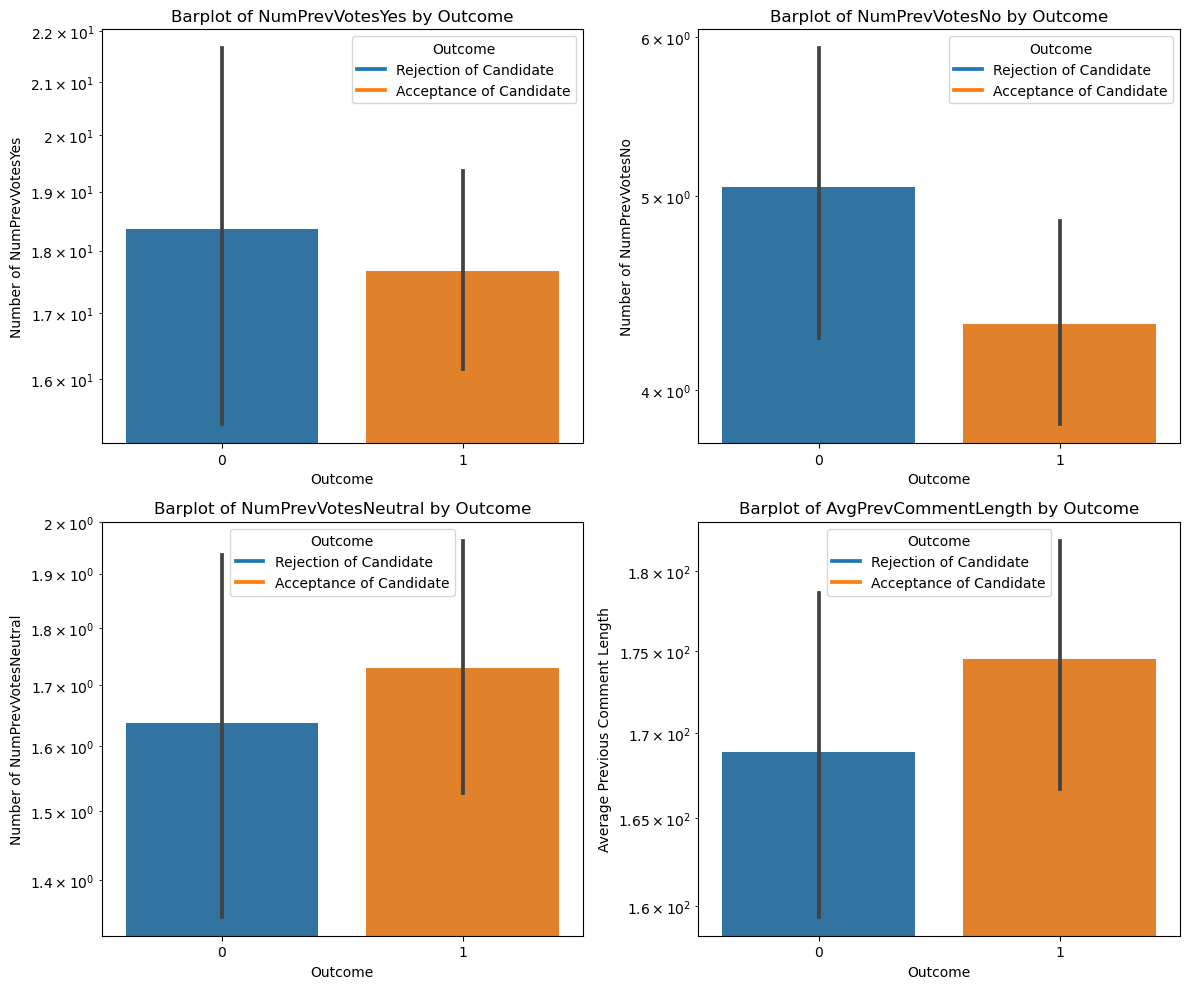

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Categories to plot
categories = ['NumPrevVotesYes', 'NumPrevVotesNo', 'NumPrevVotesNeutral', 'AvgPrevCommentLength']

for i, category in enumerate(categories):
    row = i // 2
    col = i % 2

    sns.barplot(x='RES', y=category, data=tgt_with_prev_participation, ax=axes[row, col])

    axes[row, col].set_ylabel(f'Number of {category}' if 'NumPrevVotes' in category else 'Average Previous Comment Length')
    axes[row, col].set_xlabel('Outcome')
    axes[row, col].set_title(f'Barplot of {category} by Outcome')
    axes[row, col].set_yscale('log')

    legend = axes[row, col].legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
    legend.legendHandles[0].set_color(sns.color_palette()[0])
    legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.tight_layout()

plt.show()

Upon examining the bar plot for candidates with prior voting experience, it seems that the average number of previous positive, negative, or neutral votes, as well as the average comment length before their candidacy, is consistent regardless of acceptance or rejection.

To validate these observations, let's conduct a t-test to statistically confirm the similarity between accepted and rejected candidates.

In [80]:
t_test_results = {}

for category in categories:
    data_res_0 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 0][category].dropna()
    data_res_1 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 1][category].dropna()

    t_stat, p_value = ttest_ind(data_res_0, data_res_1, alternative='two-sided')

    t_test_results[category] = {'T-statistic': t_stat, 'P-value': p_value}
    
for category, result in t_test_results.items():
    print(f"Category: {category}")
    print(f"T-statistic: {result['T-statistic']}")
    print(f"P-value: {result['P-value']}")
    print()

Category: NumPrevVotesYes
T-statistic: 0.43884699900576585
P-value: 0.6608198290092218

Category: NumPrevVotesNo
T-statistic: 1.5819644296167288
P-value: 0.11381588454628705

Category: NumPrevVotesNeutral
T-statistic: -0.49770651236585023
P-value: 0.6187456606353676

Category: AvgPrevCommentLength
T-statistic: -0.8820169915910627
P-value: 0.37787366238526654



The statistical results reveal no substantial differences in the averages, both for the various categories of votes (positive, neutral, or negative) and the length of comments. This leads to the conclusion that candidates' prior voting behavior and comment length, before aspiring to adminship, may not significantly influence the outcome of their candidacy. 

### Step 3: Margins and Outcomes - For/Against Votes Analysis

In [136]:
voters_df = create_voters_df(wiki_df)

In [140]:
elections_df = pd.merge(elections_df, wiki_df[['ELECTION_ID', 'YEA']].drop_duplicates(), on='ELECTION_ID', how='left')
elections_df

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00,2013
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00,2013
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00,2013
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00,2013
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,5,5,0,0,100.000000,0.000000,0.000000,2003-10-09 04:54:00,2003-11-09 19:16:00,2003
3924,3925,Ugen64,1,3,3,0,0,100.000000,0.000000,0.000000,2003-12-06 16:05:00,2003-12-06 16:05:00,2003
3925,3926,Vancouverguy,1,3,3,0,0,100.000000,0.000000,0.000000,2003-08-31 02:13:00,2003-09-02 02:51:00,2003
3926,3927,WhisperToMe,1,3,3,0,0,100.000000,0.000000,0.000000,2003-11-26 23:45:00,2003-12-05 05:38:00,2003


In accordance with our documentation (see link : https://en.wikipedia.org/wiki/Wikipedia:Guide_to_requests_for_adminship) a successful election requires that at least 75% of the total votes received by a candidate are positive. 

Mathematically, if we denote $x$ as the number of positive votes and $y$ as the combined number of negative and neutral votes, the candidate is likely to win when $x \geq 0.75 * (x + y)$, which means $0.25 * x \geq 0.75 * y$ therefore $x \geq 3 * y$. 

But RfA is not a straightforward majority vote, there is no precise "pass" or "fail" percentage, the 75% is only given as an approximate guide and it is the job of bureaucrats to determine the concensus results of a request for admniship.

First, let's visualize the margin for successful and unsuccessful elections for each year, from 2003 to 2013.

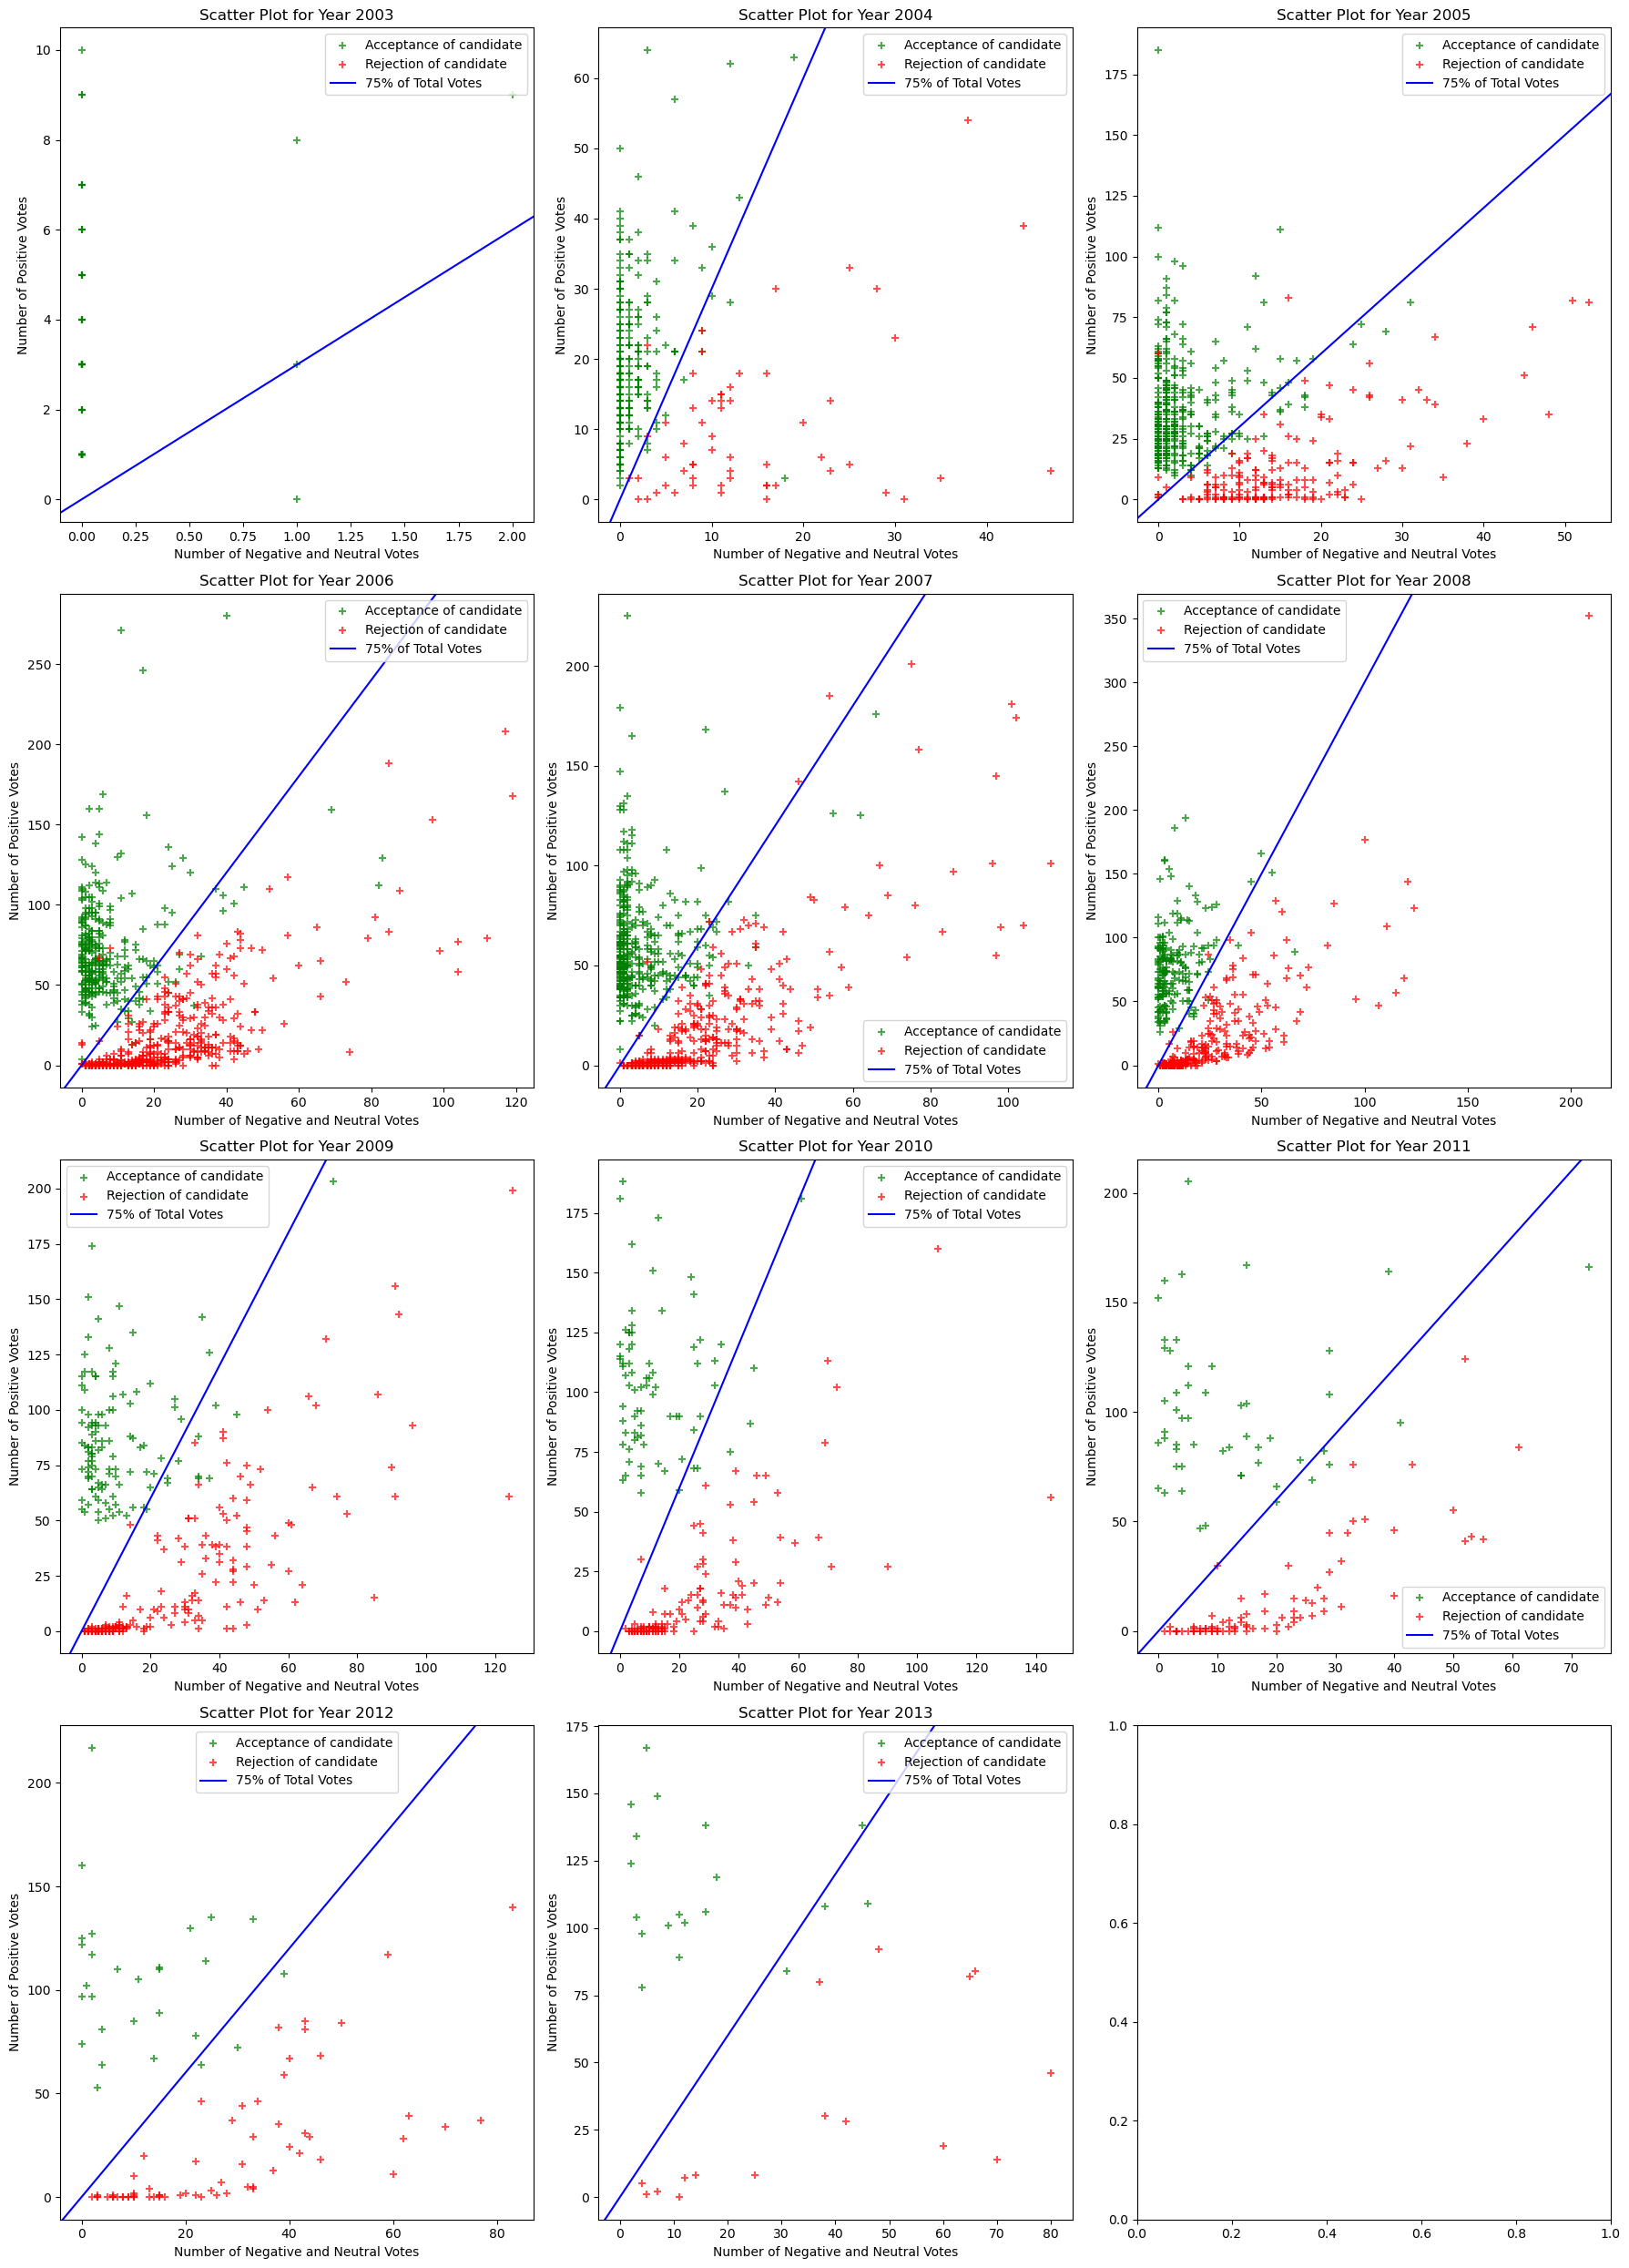

In [141]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 25))

unique_years = elections_df['YEA'].unique()

unique_years.sort()

for i, year in enumerate(unique_years):
    ax = axes[i//3][i%3]
    
    year_data = elections_df[elections_df['YEA'] == year]
    
    ax.scatter(
        y=year_data[year_data['RES'] == 1]['Positive Votes'],
        x=year_data[year_data['RES'] == 1]['Negative Votes'] + year_data[year_data['RES'] == 1]['Neutral Votes'],
        color='green',
        label='Acceptance of candidate',
        alpha=0.7,
        marker='+'
    )
    
    ax.scatter(
        y=year_data[year_data['RES'] == 0]['Positive Votes'],
        x=year_data[year_data['RES'] == 0]['Negative Votes'] + year_data[year_data['RES'] == 0]['Neutral Votes'],
        color='red',
        label='Rejection of candidate',
        alpha=0.7,
        marker='+'
    )
    
    ax.axline((0, 0), slope=3, color='blue', label='75% of Total Votes')
    
    ax.set_title(f'Scatter Plot for Year {year}')
    ax.set_xlabel('Number of Negative and Neutral Votes')
    ax.set_ylabel('Number of Positive Votes')
    ax.legend()

plt.tight_layout()
plt.show()


Let's define the margin as the difference $ y - 3x$. As previously mentioned, if the margin is $> 0$, the candidate is likely to win. To enhance comprehension, we normalize the margin by dividing it by the total number of votes.

The highest value of the margin is achieved when the number of positive votes is maximal, equivalent to the total number of votes. Conversely, the lowest value is reached when there are no positive votes. Consequently, the margin ranges from $-3$ to $1$.

In [142]:
elections_df['margin'] = (elections_df['Positive Votes'] - 3 * (elections_df['Negative Votes'] + elections_df['Neutral Votes'])) / elections_df['Total Votes']

Text(0.5, 1.0, 'Histogram of the margin')

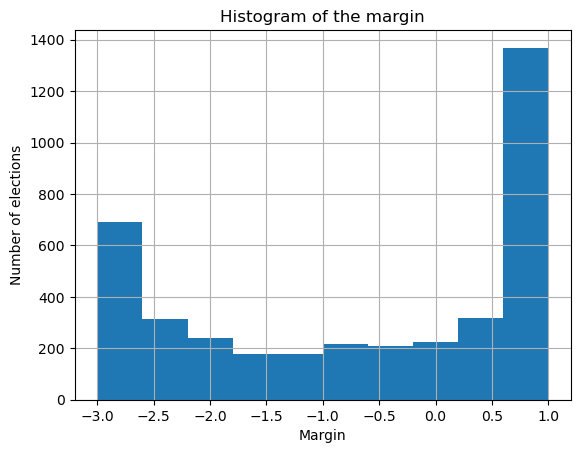

In [143]:
elections_df['margin'].hist();
plt.xlabel('Margin')
plt.ylabel('Number of elections')
plt.title('Histogram of the margin')

Let's first analyze the margin values for election leading to the acceptance of the candidates

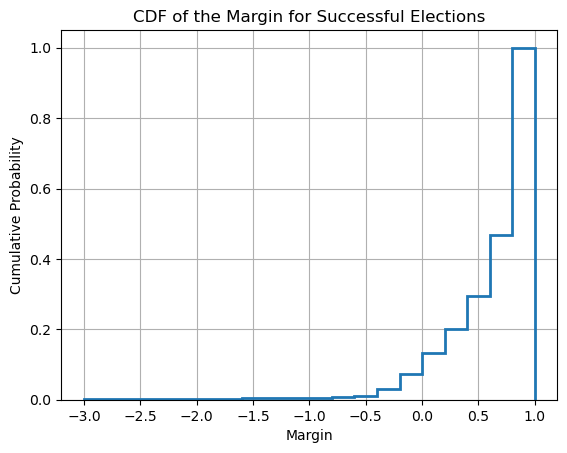

The CDF value for margin = 0 is 7.64828303850156%


In [177]:
successful_margin = elections_df[elections_df['RES'] == 1]['margin']

plt.hist(successful_margin, cumulative=True, density=True, bins=20, histtype='step', linewidth=2)
plt.xlabel('Margin')
plt.ylabel('Cumulative Probability')
plt.title('CDF of the Margin for Successful Elections')
plt.grid(True)
plt.show()

cdf_value = percentileofscore(successful_margin, 0, kind='rank')

print(f"The CDF value for margin = 0 is {cdf_value}%")

Over 93% of successful candidates have a positive margin, indicating that they meet the indicative threshold of 75% positive votes. 

But some candidates manage to win with a negative margin. Notably, there are even cases where candidates secured victory without receiving any positive votes. Let's dig deeper about them.

In [145]:
elections_df[(elections_df['margin'] == -3) & elections_df['RES'] == 1]

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,margin
1577,1578,Matt Britt,1,2,0,2,0,0.0,100.0,0.0,2007-04-18 06:23:00,2007-04-22 16:08:00,2007,-3.0
3922,3923,Tompagenet,1,1,0,0,1,0.0,0.0,100.0,NaT,NaT,2003,-3.0


We can see that for both candidates the number of participating voters is very low (1 and 2). Moreover, for the candidate `Tompagenet`, it should be note that in the year 2003, every candidacy seems to have been accepted, perhaps because it was the early days of Wikipedia. Let's analyze the comments of the voters who participated in the election of `Matt Britt`.

In [161]:
wiki_df[wiki_df['TGT'] == "Matt Britt"]["TXT"].values

array(['Strongly opposed, per reasons above. The willingness to allow others to try something new is not itself an indication that you will disrupt the encyclopedia.',
       'Oppose candidate for participating in this. If we want community input, the best way to pick candidates is through a vote. If not, do it through a lottery or by committee. The worst way is something like the mess displayed on this page. --'],
      dtype=object)

The comments reflect a strong opposition towards the candidates. However, upon further investigation, we discovered additional context by exploring the details on the Wikipedia page  https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship/Matt_Britt. This page reveals that the candidate was elected through a new exploratory alternative to the standard Request for Adminship (RfA) process. This context explains the limited number of votes in this dataset and sheds light on why the candidate was successfully elected despite receiving 100% negative votes in this particular dataset. 

As the two cases are very specific, let's remove them from the analysis.

In [166]:
elections_df[(elections_df['RES'] == 1) & (elections_df['margin'] != -3.0)]['margin'].min()

-2.4285714285714284

If we exclude the cases where there are no positive votes, the minimum margin for a candidate whose adminship was accepted is $m = -2.428$. A quick calculation reveals that the corresponding percentage of positive votes is $\frac{m+3}{4} = 0.142$, indicating that 14% of the total votes are positive.

Let's now analyze the margin values for election leading to the rejection of the candidates.

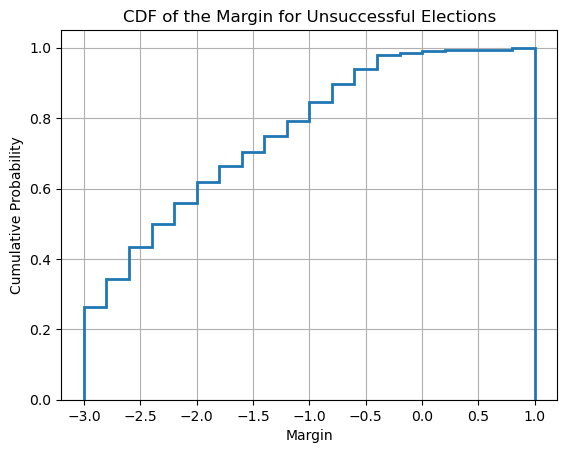

The CDF value for margin = 0 is 98.65403788634097%


In [178]:
unsuccessful_margin = elections_df[elections_df['RES'] == 0]['margin']

plt.hist(unsuccessful_margin, cumulative=True, density=True, bins=20, histtype='step', linewidth=2)
plt.xlabel('Margin')
plt.ylabel('Cumulative Probability')
plt.title('CDF of the Margin for Unsuccessful Elections')
plt.grid(True)
plt.show()

cdf_value = percentileofscore(unsuccessful_margin, 0, kind='rank')

print(f"The CDF value for margin = 0 is {cdf_value}%")

Over 98% of unsuccessful candidates have a negative margin, indicating that they do not meet the indicative threshold of 75% positive votes, thus their rejection. 

But some candidates are rejected even when their margins are positive. Notably, there are even cases where candidates where rejected even if 100% of the votes they received where positives. Let's dig deeper about them.

In [180]:
elections_df[(elections_df['margin'] == 1) & (elections_df['RES'] == 0)]

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,margin
1193,1194,matt037291,0,1,1,0,0,100.0,0.0,0.0,2008-12-22 11:06:00,2008-12-22 11:06:00,2008,1.0
2003,2004,Moralis,0,1,1,0,0,100.0,0.0,0.0,2007-04-13 14:31:00,2007-04-13 14:31:00,2007,1.0
2787,2788,LtPowers,0,1,1,0,0,100.0,0.0,0.0,2006-08-12 17:24:00,2006-08-12 17:24:00,2006,1.0
2793,2794,madcowpoo,0,14,14,0,0,100.0,0.0,0.0,2006-10-02 19:42:00,2006-10-02 21:26:00,2006,1.0
2950,2951,The Fish,0,13,13,0,0,100.0,0.0,0.0,2006-02-05 18:46:00,2006-02-08 23:27:00,2006,1.0
2988,2989,Weyes3,0,1,1,0,0,100.0,0.0,0.0,2006-03-14 09:52:00,2006-03-14 09:52:00,2006,1.0
3478,3479,Ilmari Karonen,0,1,1,0,0,100.0,0.0,0.0,2005-11-23 08:50:00,2005-11-23 08:50:00,2005,1.0
3483,3484,"Just zis Guy, you know?",0,1,1,0,0,100.0,0.0,0.0,2005-11-05 10:14:00,2005-11-05 10:14:00,2005,1.0
3494,3495,MarkGallagher,0,2,2,0,0,100.0,0.0,0.0,2005-10-28 15:48:00,2005-10-28 15:53:00,2005,1.0
3526,3527,Robchurch,0,60,60,0,0,100.0,0.0,0.0,2005-10-10 00:21:00,2005-10-16 23:57:00,2005,1.0


In [193]:
elections_df[elections_df['TGT'] == 'Robchurch']

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,margin
2882,2883,Robchurch,0,325,208,95,22,64.0,29.230769,6.769231,2005-12-28 00:14:00,2006-05-27 22:18:00,2006,-0.44
3300,3301,Robchurch,1,60,60,0,0,100.0,0.000000,0.000000,2005-10-10 00:21:00,2005-10-16 23:57:00,2005,1.00
3526,3527,Robchurch,0,60,60,0,0,100.0,0.000000,0.000000,2005-10-10 00:21:00,2005-10-16 23:57:00,2005,1.00


After conducting research on Wikipedia websites, specifically https://en.wikipedia.org/wiki/Wikipedia:Unsuccessful_adminship_candidacies/ + [first-letter-of-candidate], it becomes clear that, for the majority of these elections (with exceptions of `Moralis` and `Robchurch`), either the candidate refused the nomination, or the election was withdrawn by a bureaucrat who deemed the candidate unprepared. Thus, the margin remains at 1.0 due to the sudden end of the election but the recorded outcome is unsuccessful.

In the case of the candidate `Moralis`, the election followed a new experimental format of the RfA, which was not captured in this dataset.

The scenario involving the candidate `Robchurch` is particular. There were two distinct outcomes, initially negative and subsequently positive, for the same election. Unfortunately, the reasons for this dual outcome remain obscure.

Let's remove all these cases for better analysis.

In [194]:
elections_df[(elections_df['RES'] == 0) & (elections_df['margin'] != 1.0)]['margin'].max()

0.7222222222222222

If we exclude the cases where there are a 100% of positive votes, the maximum margin for a candidate whose adminship was not accepted is $m = 0.72$. A quick calculation reveals that the corresponding percentage of positive votes is $\frac{m+3}{4} = 0.93$, indicating that 93% of the total votes are positive.

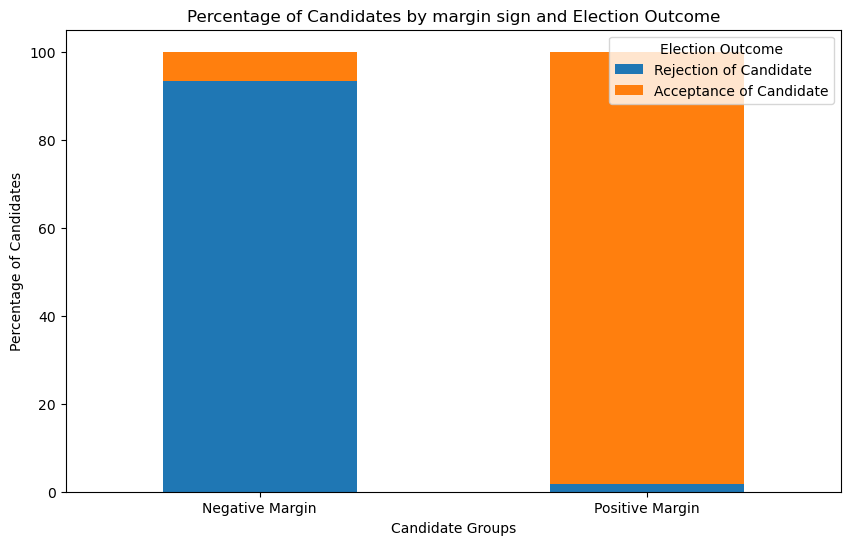

In [202]:
margin_df = elections_df.groupby(elections_df['margin'].lt(0).map({True: 'Negative Margin', False: 'Positive Margin'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = margin_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Candidate Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by margin sign and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
plt.xticks(rotation=0)

plt.show()

In [203]:
margin_df

RES,0,1
margin,,
Negative Margin,93.339632,6.660368
Positive Margin,1.656543,98.343457


In summary, aspiring administrators should target a positive margin, as over $93\%$ of successful candidates exceed the indicative threshold of $75\%$ positive votes. The minimum margin for acceptance is $-2.428$, correlating with a positive vote percentage of $14\%$. However, a positive margin alone does not guarantee success; $2\%$ of unsuccessful candidates had a positive margin, reaching up to $0.72$, corresponding to a positive vote percentage of $93\%$.

### Step 4: Neutral Ground - Analyzing Neutral Votes

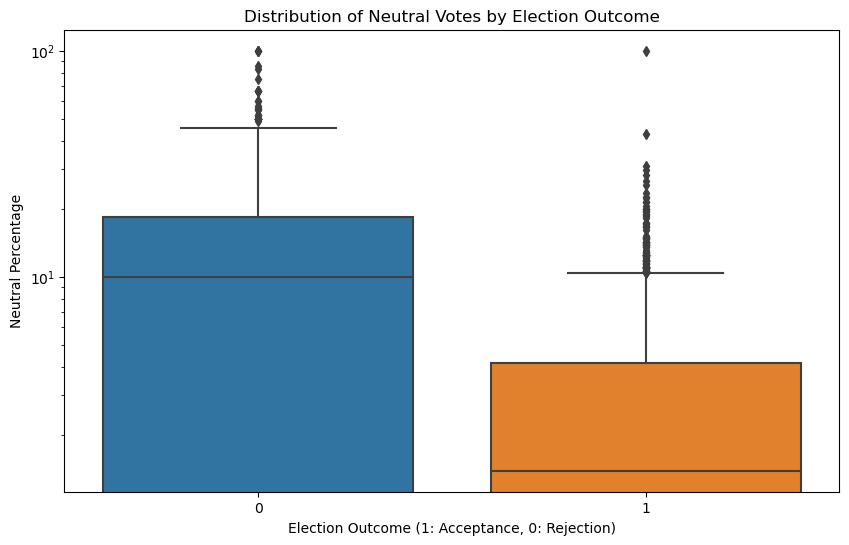

In [207]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='RES', y='Neutral Percentage', data=elections_df)
plt.xlabel('Election Outcome (1: Acceptance, 0: Rejection)')
plt.ylabel('Neutral Percentage')
plt.title('Distribution of Neutral Votes by Election Outcome')
plt.yscale('log')
plt.show()

Observing the boxplot, we notice a notable difference in the distribution of neutral votes between successful and unsuccessful elections. The median for unsuccessful elections is around $10\%$, while for successful elections, it is approximately $1\%$. This indicates a tendency for unsuccessful elections to have a higher proportion of neutral votes.

To confirm this observation, we will conduct a statistical test.

In [211]:
accepted_neutral = elections_df[elections_df['RES'] == 1]['Neutral Percentage']
rejected_neutral = elections_df[elections_df['RES'] == 0]['Neutral Percentage']

t_stat, p_value = ttest_ind(accepted_neutral, rejected_neutral, alternative='less')
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -31.779310313423153
P-value: 9.773620097370759e-198


The t-test results reveal a significant difference in the proportion of neutral votes between accepted and rejected candidates. With an extremely low p-value of 9.77e-198, we can confidently reject the null hypothesis. The observed results suggests that the neutrality of votes may play a role in election outcomes.

C:\Users\User\AppData\Local\Temp\ipykernel_17080\4284393575.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_17080\4284393575.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


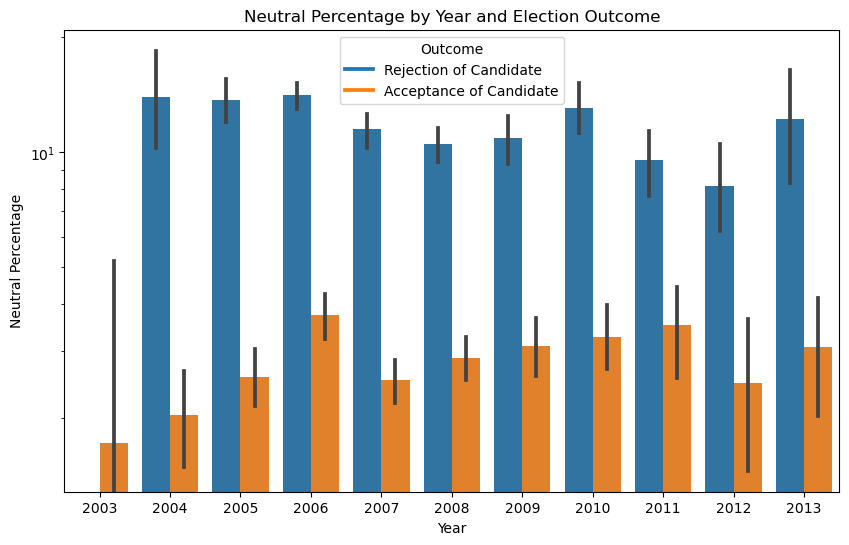

In [212]:
plt.figure(figsize=(10, 6))

sns.barplot(x='YEA', y='Neutral Percentage', hue='RES', data=elections_df)

plt.xlabel('Year')
plt.ylabel('Neutral Percentage')
plt.yscale('log')
plt.title('Neutral Percentage by Year and Election Outcome')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()